## load data and first overview

In this step I import the main Python libraries I need for analysis and plotting: pandas, matplotlib and seaborn.
Then I load the training dataset from the CSV file into a pandas DataFrame called `df`.
With `df.head()` I look at the first five rows to understand how the data looks.
Finally, `df.shape` and `df.dtypes` give me the number of rows/columns and the data type of each variable, so I know what I am working with.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

data_path = "../Dataset/train.csv"
df = pd.read_csv(data_path)

df.head()


/var/folders/s2/5bq1zxz135v1jbk0mrrrrt8h0000gn/T/ipykernel_2464/3182516783.py:8: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [3]:
#Basic information about the dataset
df.shape, df.dtypes


((100000, 28),
 ID                           object
 Customer_ID                  object
 Month                        object
 Name                         object
 Age                          object
 SSN                          object
 Occupation                   object
 Annual_Income                object
 Monthly_Inhand_Salary       float64
 Num_Bank_Accounts             int64
 Num_Credit_Card               int64
 Interest_Rate                 int64
 Num_of_Loan                  object
 Type_of_Loan                 object
 Delay_from_due_date           int64
 Num_of_Delayed_Payment       object
 Changed_Credit_Limit         object
 Num_Credit_Inquiries        float64
 Credit_Mix                   object
 Outstanding_Debt             object
 Credit_Utilization_Ratio    float64
 Credit_History_Age           object
 Payment_of_Min_Amount        object
 Total_EMI_per_month         float64
 Amount_invested_monthly      object
 Payment_Behaviour            object
 Monthly_Balance       

## automatic variable type detection

Here I define a helper function `detect_variable_types()` to classify each column in the dataset.
The function loops over all columns and checks if they are the target, datetime, numeric, binary, categorical, or text variables.
For numeric columns it looks at the number of unique values to decide if a feature is binary or general numerical.
For object columns it uses the number of unique values and the average string length to decide if they are short categorical labels or longer text fields.
This automatic mapping helps later when I choose the right preprocessing and modelling steps for each variable type.

In [4]:
def detect_variable_types(df, target_col=None):
    """Automatically detect variable types in a DataFrame"""
    types = {}
    
    for col in df.columns:
        if col == target_col:
            types[col] = 'target'
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            types[col] = 'datetime'
        elif pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() == 2:
                types[col] = 'binary'
            else:
                types[col] = 'numerical'
        elif df[col].nunique() < 20:
            types[col] = 'categorical'
        elif df[col].dtype == 'object':
            avg_length = df[col].astype(str).str.len().mean()
            if avg_length > 50:
                types[col] = 'text'
            else:
                types[col] = 'categorical'
    return types

print(detect_variable_types(df, None))

{'ID': 'categorical', 'Customer_ID': 'categorical', 'Month': 'categorical', 'Name': 'categorical', 'Age': 'categorical', 'SSN': 'categorical', 'Occupation': 'categorical', 'Annual_Income': 'categorical', 'Monthly_Inhand_Salary': 'numerical', 'Num_Bank_Accounts': 'numerical', 'Num_Credit_Card': 'numerical', 'Interest_Rate': 'numerical', 'Num_of_Loan': 'categorical', 'Type_of_Loan': 'text', 'Delay_from_due_date': 'numerical', 'Num_of_Delayed_Payment': 'categorical', 'Changed_Credit_Limit': 'categorical', 'Num_Credit_Inquiries': 'numerical', 'Credit_Mix': 'categorical', 'Outstanding_Debt': 'categorical', 'Credit_Utilization_Ratio': 'numerical', 'Credit_History_Age': 'categorical', 'Payment_of_Min_Amount': 'categorical', 'Total_EMI_per_month': 'numerical', 'Amount_invested_monthly': 'categorical', 'Payment_Behaviour': 'categorical', 'Monthly_Balance': 'categorical', 'Credit_Score': 'categorical'}


## missing values and basic range checks

In this part I analyse data quality.
The function `quick_missing_analysis()` calculates how many values are missing in each column and the percentage of missingness.
It prints a short summary so I can see which variables have serious missing data problems and may need imputation or removal.
The function `basic_range_check()` focuses on numerical columns and prints their minimum and maximum values.
It also has a simple check for suspicious values (for example negative ages or ages above 120), which can indicate errors or outliers that I should clean.

In [5]:
def quick_missing_analysis(df):
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100
    
    print("Missing Value Summary:")
    for col in df.columns:
        if missing_counts[col] > 0:
            print(f"  {col}: {missing_counts[col]} missing ({missing_percent[col]:.1f}%)")

print(quick_missing_analysis(df))

Missing Value Summary:
  Name: 9985 missing (10.0%)
  Monthly_Inhand_Salary: 15002 missing (15.0%)
  Type_of_Loan: 11408 missing (11.4%)
  Num_of_Delayed_Payment: 7002 missing (7.0%)
  Num_Credit_Inquiries: 1965 missing (2.0%)
  Credit_History_Age: 9030 missing (9.0%)
  Amount_invested_monthly: 4479 missing (4.5%)
  Monthly_Balance: 1200 missing (1.2%)
None


In [6]:
# Quick sanity checks for numerical data
def basic_range_check(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    for col in numeric_cols:
        print(f"{col}: min={df[col].min()}, max={df[col].max()}")
        
        # Flag obviously problematic values
        if col.lower() in ['age'] and (df[col].min() < 0 or df[col].max() > 120):
            print(f"  ⚠️ Suspicious age values detected")

print(basic_range_check(df))

Monthly_Inhand_Salary: min=303.6454166666666, max=15204.633333333331
Num_Bank_Accounts: min=-1, max=1798
Num_Credit_Card: min=0, max=1499
Interest_Rate: min=1, max=5797
Delay_from_due_date: min=-5, max=67
Num_Credit_Inquiries: min=0.0, max=2597.0
Credit_Utilization_Ratio: min=20.0, max=50.00000000000001
Total_EMI_per_month: min=0.0, max=82331.0
None


## Z-score outlier detection

Here I use a simple statistical method to detect outliers in a numerical column.
The function `find_zscore_outliers()` computes the mean and standard deviation of the selected feature and then calculates the Z-score for each observation.
If the absolute Z-score is greater than the chosen threshold (here 3), the observation is flagged as an outlier.
I apply this function to the column `Monthly_Inhand_Salary` and print how many extreme values are found, together with a preview of these rows.
This helps me to understand if salary values contain unrealistic observations that could distort the model.

In [7]:
# Simple z-score outlier detection
def find_zscore_outliers(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    z_scores = abs((data[column] - mean) / std)
    
    outliers = data[z_scores > threshold]
    print(f"Found {len(outliers)} outliers using Z-score method")
    return outliers

print(find_zscore_outliers(df, "Monthly_Inhand_Salary"))


Found 879 outliers using Z-score method
            ID Customer_ID     Month      Name Age          SSN  Occupation  \
1728    0x2022  CUS_0x2c31   January     Yokog  30  680-06-0631    Musician   
1729    0x2023  CUS_0x2c31  February     Yokog  30  680-06-0631    Musician   
1730    0x2024  CUS_0x2c31     March     Yokog  30  680-06-0631    Musician   
1731    0x2025  CUS_0x2c31     April     Yokog  30  680-06-0631    Musician   
1732    0x2026  CUS_0x2c31       May     Yokog  30  680-06-0631    Musician   
...        ...         ...       ...       ...  ..          ...         ...   
98931  0x259ad  CUS_0x1f97     April  Hitoshio  49  346-14-6418  Journalist   
98932  0x259ae  CUS_0x1f97       May       NaN  49  346-14-6418  Journalist   
98933  0x259af  CUS_0x1f97      June  Hitoshio  49  346-14-6418  Journalist   
98934  0x259b0  CUS_0x1f97      July  Hitoshio  49  346-14-6418  Journalist   
98935  0x259b1  CUS_0x1f97    August  Hitoshio  50  346-14-6418  Journalist   

      Annua

## missing values table and target distribution

First I create a sorted table of missing values using `df.isna().sum().sort_values(ascending=False)`.
This gives a clear overview of which variables have the most missing data and supports decisions about imputation or dropping variables.
Next I define the target column `Credit_Score` and calculate the relative frequency of each class with `value_counts(normalize=True)`.
The output shows how many customers are classified as “Good”, “Standard”, and “Poor”, and if the classes are balanced or imbalanced.
Knowing the target distribution is important for selecting appropriate evaluation metrics and possibly using class-balancing techniques.

In [8]:
#Missing Values
df.isna().sum().sort_values(ascending=False)

Monthly_Inhand_Salary       15002
Type_of_Loan                11408
Name                         9985
Credit_History_Age           9030
Num_of_Delayed_Payment       7002
Amount_invested_monthly      4479
Num_Credit_Inquiries         1965
Monthly_Balance              1200
ID                              0
Changed_Credit_Limit            0
Payment_Behaviour               0
Total_EMI_per_month             0
Payment_of_Min_Amount           0
Credit_Utilization_Ratio        0
Outstanding_Debt                0
Credit_Mix                      0
Delay_from_due_date             0
Customer_ID                     0
Num_of_Loan                     0
Interest_Rate                   0
Num_Credit_Card                 0
Num_Bank_Accounts               0
Annual_Income                   0
Occupation                      0
SSN                             0
Age                             0
Month                           0
Credit_Score                    0
dtype: int64

In [9]:
# Target distribution (adjust target name)
target_col = "Credit_Score"
df[target_col].value_counts(normalize=True)


Credit_Score
Standard    0.53174
Poor        0.28998
Good        0.17828
Name: proportion, dtype: float64

## visualising class balance

In this cell I visualise the target distribution using a seaborn `countplot`.
On the x-axis I plot the `Credit_Score` classes and on the y-axis the number of observations in each class.
The bar chart makes it easy to see that the “Standard” class is the largest group, followed by “Poor” and “Good”.
This visual check confirms the numerical proportions from the previous step and highlights any class imbalance that could affect the classifier.

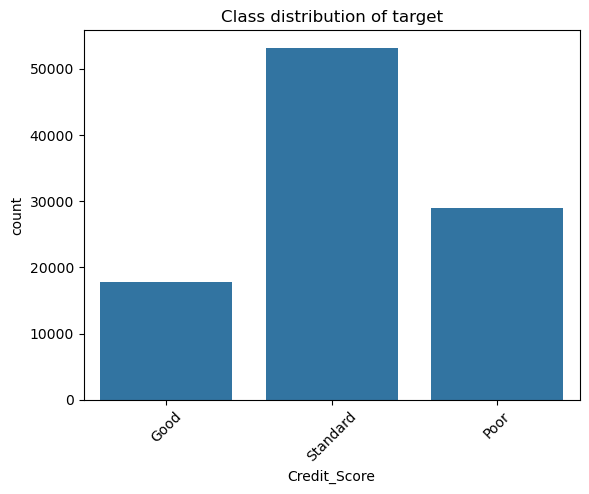

In [10]:
# Plot class balance
sns.countplot(x=target_col, data=df)
plt.title("Class distribution of target")
plt.xticks(rotation=45)
plt.show()


## numeric features summary and histograms

Finally, I focus on the numerical features of the dataset.
I select all integer and float columns and use `describe()` to get summary statistics such as mean, standard deviation, minimum, maximum, and quartiles.
These statistics show the central tendency and spread of each numerical variable and help to detect skewness or extreme values.
Below, I loop over all numeric columns and draw a histogram with a kernel density estimate for each one.
The histograms give a visual impression of the distributions (for example normal, skewed, or multi-modal), which is useful for choosing transformations and modelling techniques later.

In [11]:
# Numeric feature distributions
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

df[numeric_cols].describe()


,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


## histogram loop (all numeric features)

In this part I create histograms for each numerical column in the dataset.
Inside a loop, I generate one plot per feature using `sns.histplot()` together with a KDE curve.
These visualisations help me understand the shape of each distribution, for example whether the feature is skewed, has long tails, or contains extreme outliers.
This is important for deciding later if I need transformations such as log-scaling, winsorization, or standardisation.

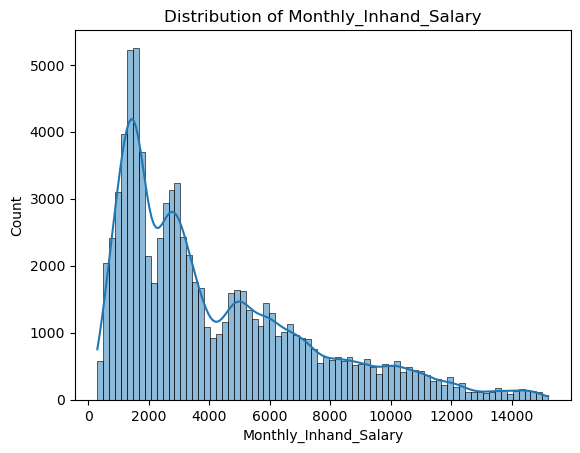

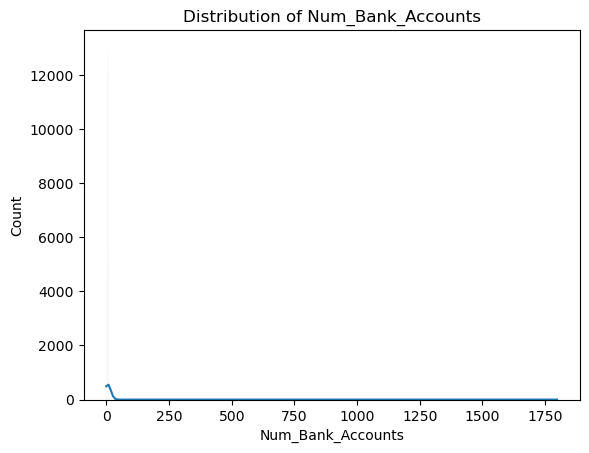

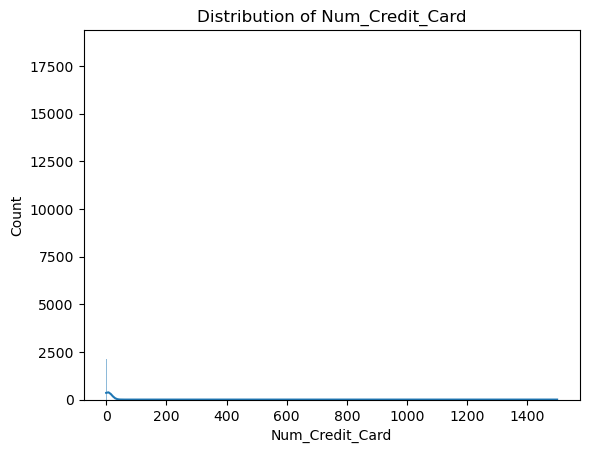

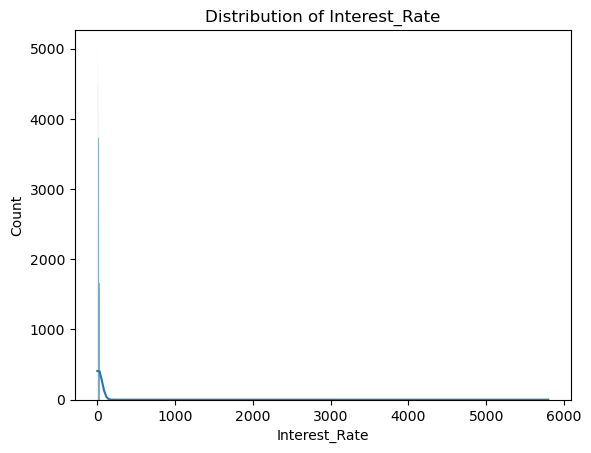

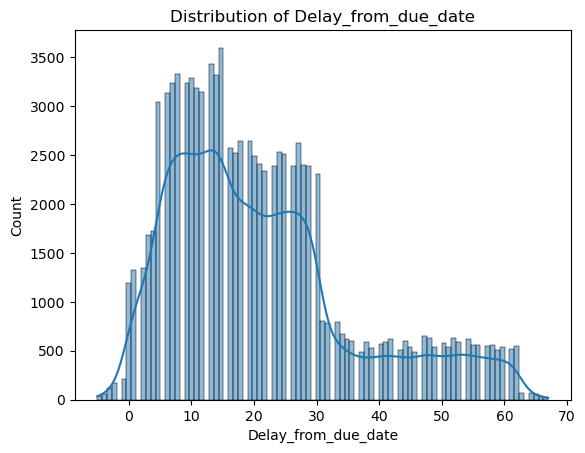

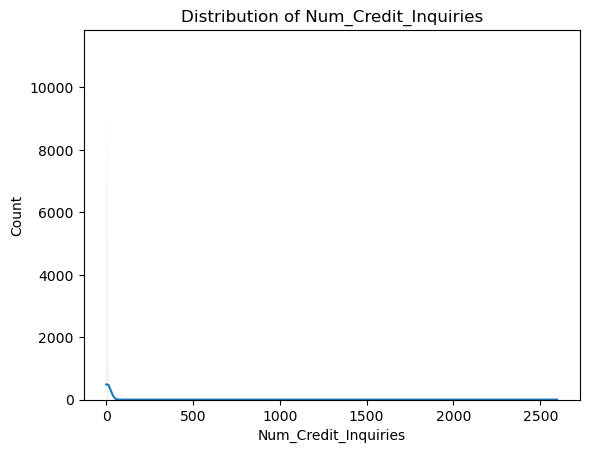

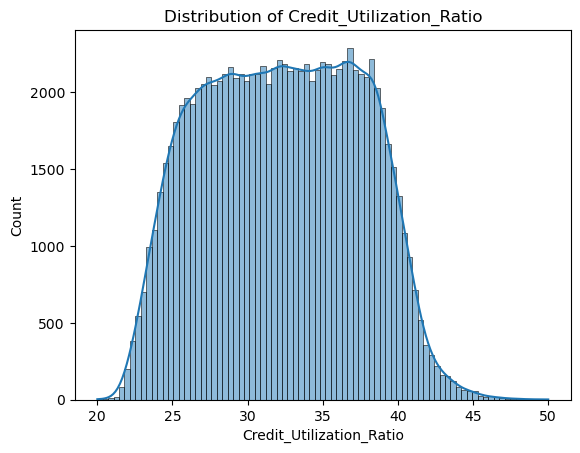

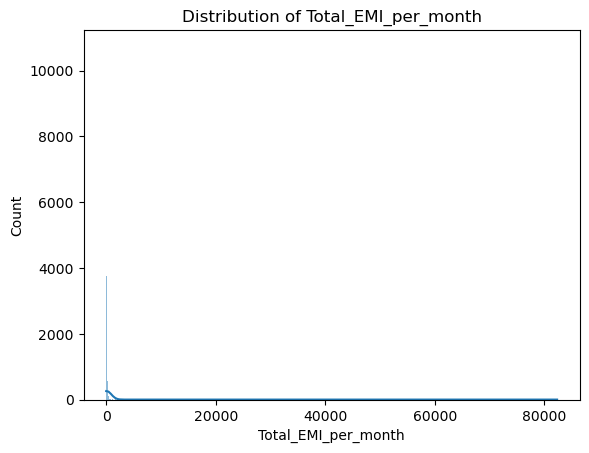

In [12]:
# Example: histogram of a numeric feature
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


## distributions of numerical features

The series of plots shows the distribution of each numerical variable.
Some features (for `example Monthly_Inhand_Salary` and `Delay_from_due_date`) show more natural spread and are close to slightly skewed distributions.
Other features like `Num_Bank_Accounts`, `Num_Credit_Card`, `Num_Credit_Inquiries`, and `Total_EMI_per_month` have very long right tails with a few extreme values.
These heavy-tailed distributions indicate that outliers or unrealistic numbers are present and may need cleaning or robust scaling before model training.
The `Credit_Utilization_Ratio` has a more compact shape and seems close to a truncated normal distribution.

## correlation heatmap

In this cell I calculate the correlation matrix for all numerical features and visualise it using a seaborn heatmap.
The heatmap helps me quickly see which variables are strongly related.
Most correlations in this dataset are weak, meaning that the numerical features are largely independent of each other.
The only moderate correlation appears between some credit-related variables and `Total_EMI_per_month`.
Understanding correlations is useful because highly correlated features may require dimensionality reduction, while uncorrelated features are generally more informative for machine learning models.

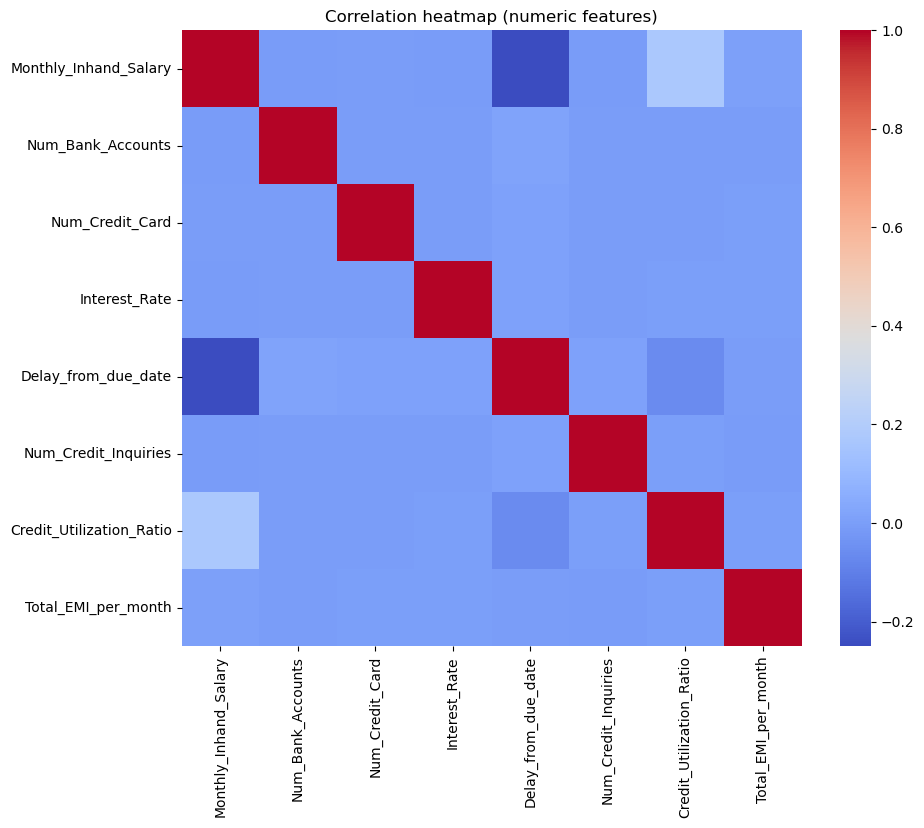

In [13]:
# Correlation heatmap for numeric features
plt.figure(figsize=(10, 8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation heatmap (numeric features)")
plt.show()
